# TimeSeries at a Point

In [183]:
import cmocean.cm as cm
import copy
import gsw
import matplotlib.pyplot as plt
from mocsy import mocsy
import numpy as np
import xarray as xr

In [184]:
# make land versions of cmaps, land is grey
cm_salt = copy.copy(cm.haline)
cm_salt.set_bad('grey')
cm_bwr = copy.copy(cm.balance)
cm_bwr.set_bad('grey')
cm_temp = copy.copy(cm.thermal)
cm_temp.set_bad('grey')
cm_deep = copy.copy(cm.deep)
cm_deep.set_bad('grey')

In [185]:
ii, jj = 448, 306
#ii, jj = 650, 160

In [186]:
jmin, jmax = 270, 330
imin, imax = 420, 480
xcy = 447
ycx = 305

In [187]:
# mesh mask file for land mask
meshmask = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
tmask = meshmask.tmask[0]
tmask = tmask.rename({'z': 'deptht'})
e3t = meshmask.e3t_0[0]
e3t = e3t.rename({'z': 'deptht'})
mbathy = meshmask.mbathy[0]

In [188]:
print (mbathy[ii, jj].values)
print (e3t[mbathy[ii, jj]-1, ii, jj].values)
mbat = mbathy[ii, jj].values
totaldepth = np.array(e3t[:mbat, ii, jj].values).sum()
print (totaldepth)

27
5.4178929247492364
92.2664648159085


In [189]:
# data files
grid = xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01may18/SalishSea_1h_20180501_20180501_grid_T.nc')

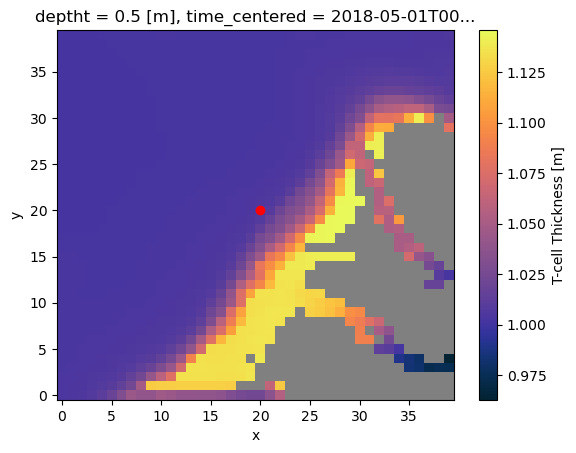

In [190]:
grid.e3t[0, 0, ii-20:ii+20, jj-20:jj+20].where(tmask[0, ii-20:ii+20, jj-20:jj+20]).plot(cmap=cm_temp)
plt.plot(20, 20, 'ro');

In [191]:
ze3t = grid.e3t[:, :, ii, jj]
zgdept = np.zeros_like(ze3t)
print (zgdept.shape)

(24, 40)


In [192]:
for kk in range(mbat):
    zgdept[:, kk] = ze3t[:, :kk].sum(axis=1) + 0.5*ze3t[:, kk]

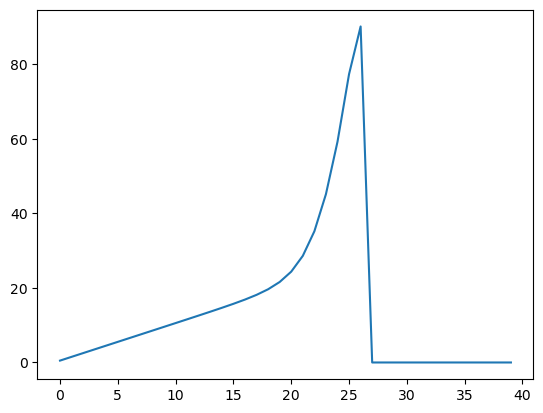

In [193]:
plt.plot(zgdept[0]);

In [194]:
np.interp(40, zgdept[0, :mbat], zgdept[0, :mbat])

40.0

In [195]:
phys = xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01may18/SalishSea_1h_20180501_20180501_grid_T.nc')
chem = xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01may18/SalishSea_1h_20180501_20180501_chem_T.nc')
biol = xr.open_dataset('/results2/SalishSea/nowcast-green.202111/01may18/SalishSea_1h_20180501_20180501_biol_T.nc')

In [196]:
dic = chem['dissolved_inorganic_carbon'][:, :, ii, jj]
ta = chem['total_alkalinity'][:, :, ii, jj]
sal = phys['vosaline'][:, :, ii, jj]

In [197]:
def interp_ts(depth, variable, zgdept=zgdept):
    dic_40 = np.zeros(24)
    for tt in range(24):
        dic_40[tt] = np.interp(depth, zgdept[tt, :mbat], variable[tt, :mbat])
    return dic_40

In [198]:
dic_70 = interp_ts(70, dic)
dic_0p5 = interp_ts(0.5, dic)

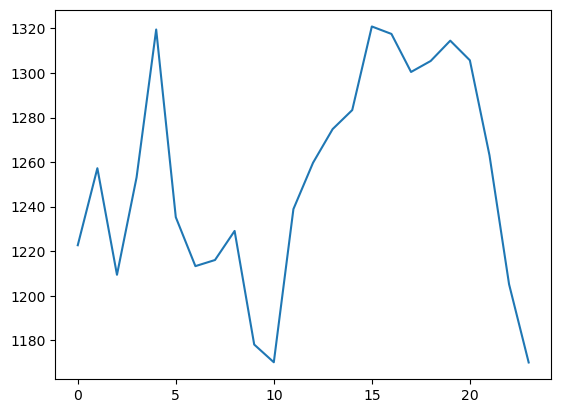

In [199]:
plt.plot(dic_0p5);

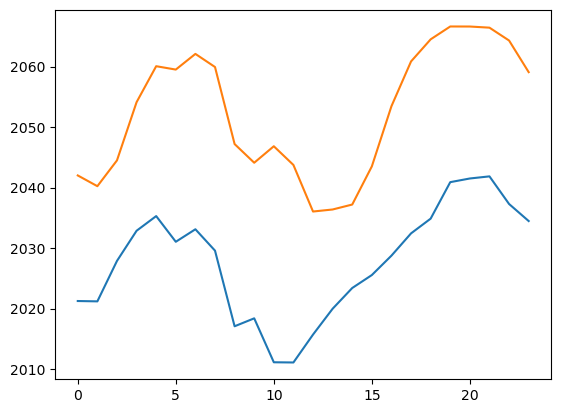

In [200]:
dic_40 = interp_ts(40, dic)
plt.plot(dic_40);
plt.plot(dic_70);

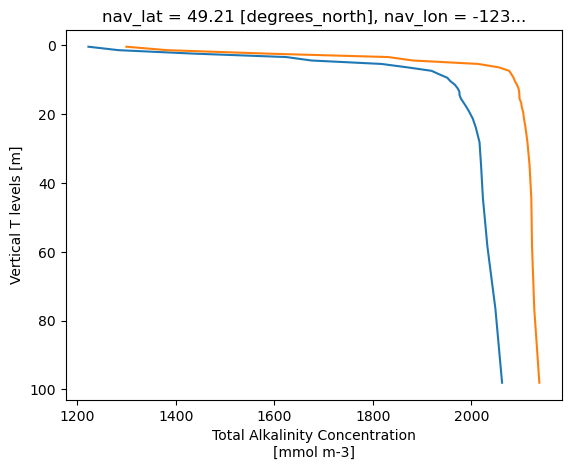

In [201]:
dic[0, :mbat].plot(y='deptht', yincrease=False)
ta[0, :mbat].plot(y='deptht', yincrease=False);

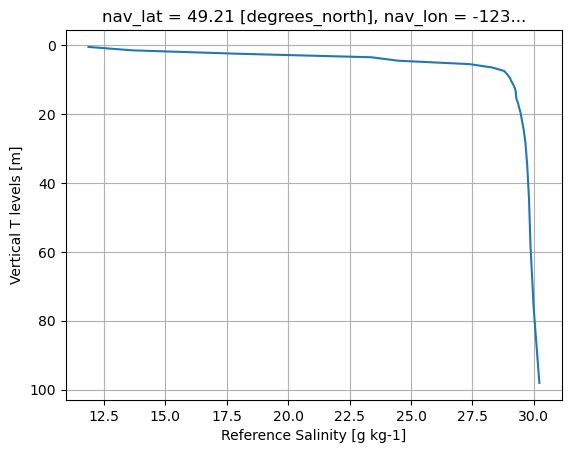

In [202]:
sal[0, :mbat].plot(y='deptht', yincrease=False);
plt.grid();

In [203]:
dic_s30 = interp_ts(30, dic, zgdept=sal)

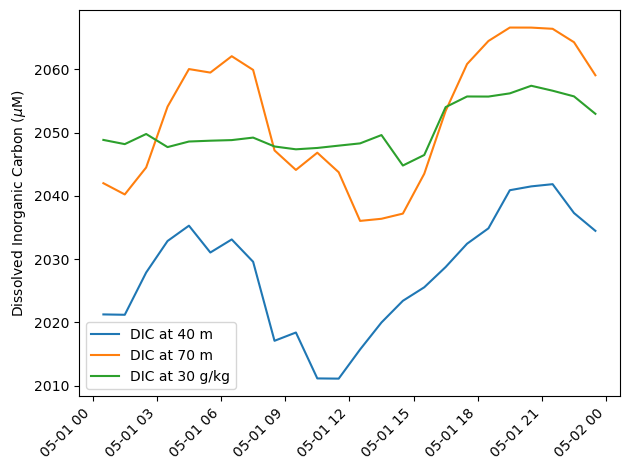

In [204]:
fig, ax = plt.subplots(1, 1)
ax.plot(sal.time_counter, dic_40, label='DIC at 40 m')
ax.plot(sal.time_counter, dic_70, label='DIC at 70 m');
ax.plot(sal.time_counter, dic_s30, label='DIC at 30 g/kg');
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), minor=False, rotation=45, ha='right');
ax.set_ylabel('Dissolved Inorganic Carbon ($\mu$M)')
ax.legend();
fig.tight_layout()
fig.savefig('dic.png', dpi=300)

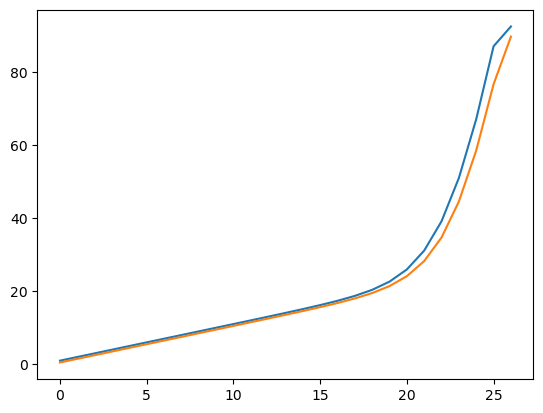

In [205]:
plt.plot(meshmask.gdepw_0[0, 1:mbat+1, ii, jj].values)
plt.plot(meshmask.gdept_0[0, :mbat, ii, jj].values);

In [206]:
scale = 40
zdepth = np.zeros_like(meshmask.gdepw_0[0, 0, ii-scale:ii+scale ,jj-scale:jj+scale])
for si, id in enumerate(range(ii-scale, ii+scale)):
    for sj, jd in enumerate(range(jj-scale, jj+scale)):
        zdepth[si, sj] = meshmask.gdepw_0[0, mbathy[id, jd].values, id, jd]

/tmp/ipykernel_2914220/1397919822.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  colours = ax.pcolormesh(meshmask.nav_lon[ii-scale:ii+scale, jj-scale:jj+scale],


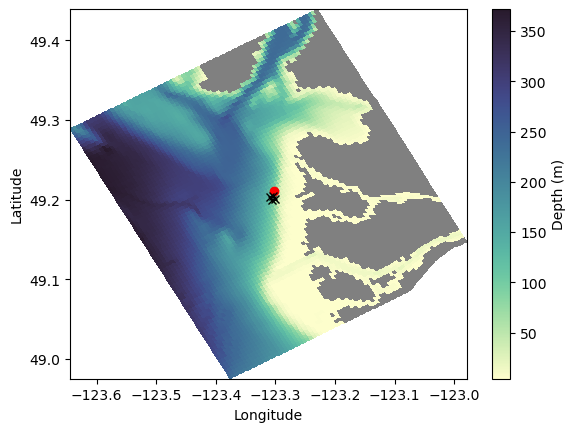

In [207]:
fig, ax = plt.subplots(1, 1)
scale = 40
colours = ax.pcolormesh(meshmask.nav_lon[ii-scale:ii+scale, jj-scale:jj+scale], 
               meshmask.nav_lat[ii-scale:ii+scale, jj-scale:jj+scale],
               np.ma.array(zdepth, mask = 1-tmask[0, ii-scale:ii+scale, jj-scale:jj+scale]), cmap=cm_deep);
ax.plot(meshmask.nav_lon[ii, jj], meshmask.nav_lat[ii, jj], 'ro');
ax.plot(meshmask.nav_lon[446:448, 304:306], meshmask.nav_lat[446:448, 304:306], 'kx');
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
cb = fig.colorbar(colours, ax=ax);
cb.set_label('Depth (m)')
fig.savefig('location.png', dpi=300)

/tmp/ipykernel_2914220/871708772.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  colours = ax.pcolormesh(meshmask.nav_lon[ii-scale:ii+scale, jj-scale:jj+scale],


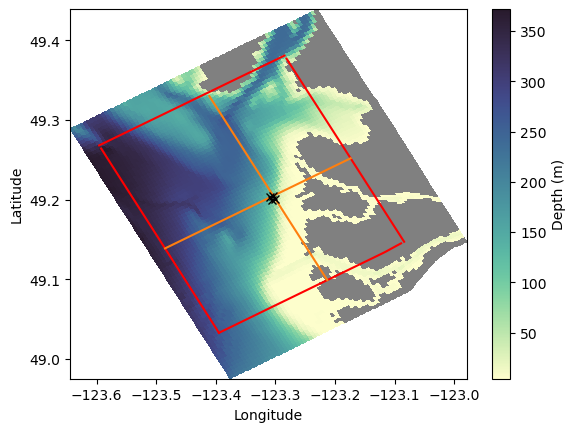

In [215]:
fig, ax = plt.subplots(1, 1)
scale = 40
colours = ax.pcolormesh(meshmask.nav_lon[ii-scale:ii+scale, jj-scale:jj+scale], 
               meshmask.nav_lat[ii-scale:ii+scale, jj-scale:jj+scale],
               np.ma.array(zdepth, mask = 1-tmask[0, ii-scale:ii+scale, jj-scale:jj+scale]), cmap=cm_deep);
ax.plot(meshmask.nav_lon[imin:imax, jmin], meshmask.nav_lat[imin:imax, jmin], 'r');
ax.plot(meshmask.nav_lon[imin:imax, jmax], meshmask.nav_lat[imin:imax, jmax], 'r');
ax.plot(meshmask.nav_lon[imin, jmin:jmax], meshmask.nav_lat[imin, jmin:jmax], 'r');
ax.plot(meshmask.nav_lon[imax, jmin:jmax+1], meshmask.nav_lat[imax, jmin:jmax+1], 'r');
ax.plot(meshmask.nav_lon[xcy, jmin:jmax+1], meshmask.nav_lat[xcy, jmin:jmax+1], color='tab:orange');
ax.plot(meshmask.nav_lon[imin:imax, ycx], meshmask.nav_lat[imin:imax, ycx], 'tab:orange');


ax.plot(meshmask.nav_lon[446:448, 304:306], meshmask.nav_lat[446:448, 304:306], 'kx');
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
cb = fig.colorbar(colours, ax=ax);
cb.set_label('Depth (m)')
fig.savefig('location2.png', dpi=300)

In [156]:
temp_insitu = gsw.t_from_CT(sal[:, :mbat].values, phys['votemper'][:, :mbat, ii, jj].values, 0)
temp_insitu.shape

(24, 27)

In [157]:
sal_psu = gsw.SP_from_SA(sal[:, :mbat].values, 0, -125, 49)
sal_psu.shape

(24, 27)

In [158]:
alk = ta[:, :mbat].values
alk.shape

(24, 27)

In [159]:
sil = biol['silicon'][:, :mbat, ii, jj].values/1000.

In [160]:
phos = biol['nitrate'][:, :mbat, ii, jj].values/16./1000.

In [161]:
depth = 40  # I could do better here.

In [162]:
ones = np.ones_like(sil.flatten())
response_tup = mocsy.mvars(temp=temp_insitu.flatten(), sal=sal_psu.flatten(), alk=alk.flatten()/1000., 
                           dic=dic[:, :mbat].values.flatten()/1000., 
                       sil=sil.flatten(), phos=phos.flatten(), patm=0.*ones, depth=depth*ones, lat=50*ones, 
                        optcon='mol/m3', optt='Tinsitu', optp='m',
                        optb = 'l10', optk1k2='m10', optkf = 'dg', optgas = 'Pinsitu')
pH,pco2,fco2,sco2,hco3,co3,OmegaA,OmegaC,BetaD,DENis,p,Tis = response_tup

In [163]:
pH = pH.reshape((24, mbat))
OmegaA = OmegaA.reshape((24, mbat))

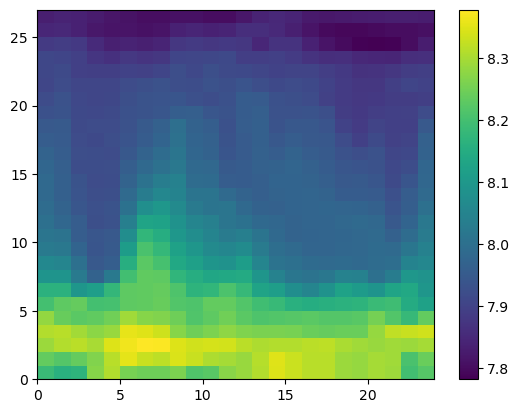

In [164]:
colours = plt.pcolormesh(pH.transpose())
plt.colorbar();

In [165]:
pH_70 = interp_ts(70, pH)
pH_s30 = interp_ts(30, pH, zgdept=sal)

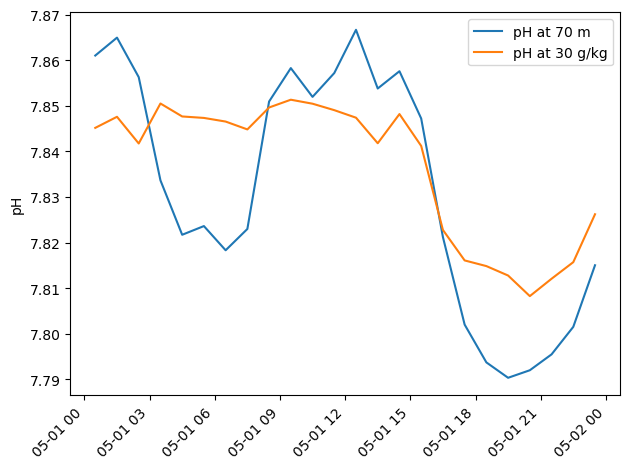

In [181]:
fig, ax = plt.subplots(1, 1)
ax.plot(sal.time_counter, pH_70, label='pH at 70 m');
ax.plot(sal.time_counter, pH_s30, label='pH at 30 g/kg');
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), minor=False, rotation=45, ha='right');
ax.legend();
ax.set_ylabel('pH')
fig.tight_layout()
fig.savefig('pH.png', dpi=300);

In [167]:
omega_70 = interp_ts(70, OmegaA)
omega_s30 = interp_ts(30, OmegaA, zgdept=sal)

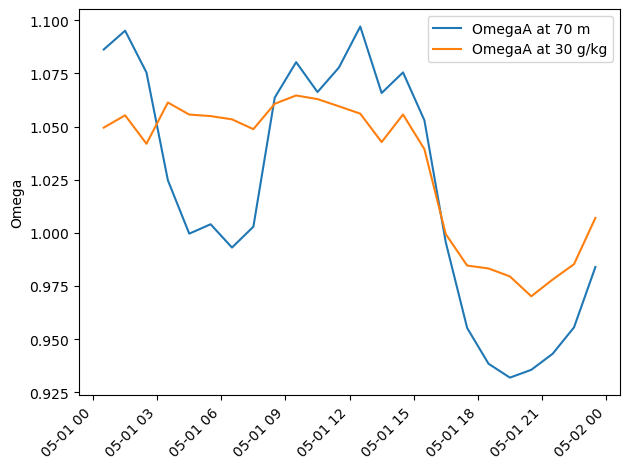

In [182]:
fig, ax = plt.subplots(1, 1)
ax.plot(sal.time_counter, omega_70, label='OmegaA at 70 m');
ax.plot(sal.time_counter, omega_s30, label='OmegaA at 30 g/kg');
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), minor=False, rotation=45, ha='right');
ax.legend();
ax.set_ylabel('Omega')
fig.tight_layout()
fig.savefig('OmegaA.png', dpi=300);

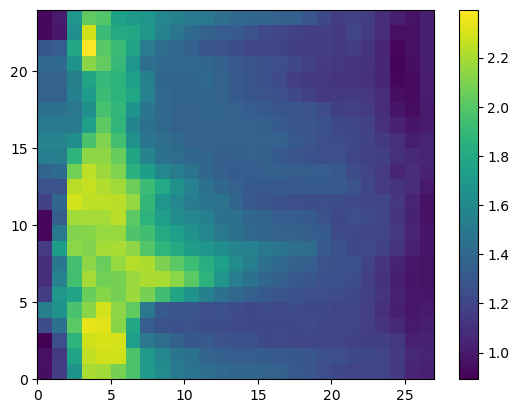

In [169]:
plt.pcolormesh(OmegaA)
plt.colorbar()